<a href="https://colab.research.google.com/github/AbdurRahman22224/Emotion_Detection/blob/main/Emotion_Detection_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Setting Up Kaggle Directory

In [16]:
!mkdir -p ./kaggle
!cp kaggle.json ./kaggle/

cp: cannot stat 'kaggle.json': No such file or directory


In [17]:
!kaggle datasets download -d msambare/fer2013

Dataset URL: https://www.kaggle.com/datasets/msambare/fer2013
License(s): DbCL-1.0
 81% 49.0M/60.3M [00:00<00:00, 103MB/s] 
100% 60.3M/60.3M [00:00<00:00, 97.3MB/s]


In [18]:
!unzip /content/fer2013.zip -d /content/

Streaming output truncated to the last 5000 lines.
  inflating: /content/train/surprise/Training_18954209.jpg  
  inflating: /content/train/surprise/Training_18960850.jpg  
  inflating: /content/train/surprise/Training_18962273.jpg  
  inflating: /content/train/surprise/Training_18964491.jpg  
  inflating: /content/train/surprise/Training_18999272.jpg  
  inflating: /content/train/surprise/Training_19011238.jpg  
  inflating: /content/train/surprise/Training_19028689.jpg  
  inflating: /content/train/surprise/Training_19085888.jpg  
  inflating: /content/train/surprise/Training_99984132.jpg  


### Installing Packages

In [19]:
import os
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import imghdr
import tensorflow as tf
from PIL import Image
import seaborn as sns

from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
from sklearn.utils.class_weight import compute_class_weight

from tensorflow.keras import layers, models, regularizers, optimizers
from tensorflow.keras.applications import VGG16, ResNet50V2
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, TensorBoard, CSVLogger
from tensorflow.keras.layers import Conv2D, MaxPooling2D, BatchNormalization, Dropout, Flatten, Dense, Activation, GlobalAveragePooling2D
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from keras.utils import plot_model

### Setting up Directory to save model data.

In [20]:
os.makedirs('test_dir', exist_ok=True)

In [21]:
# Define your project name
project_name = 'FER_2013_Emotion_Detection'

# List your models
model_names = [
    'ResNet50_Transfer_Learning'
]

# Base directory (in this case, your Google Colab workspace)
base_dir = '/content/'

# Create the project directory
project_dir = os.path.join(base_dir, project_name)
os.makedirs(project_dir, exist_ok=True)

# Create a subdirectory for each model
for each_model in model_names:
    model_dir = os.path.join(project_dir, each_model)
    os.makedirs(model_dir, exist_ok=True)
    os.makedirs(os.path.join(model_dir, 'checkpoints'), exist_ok=True)
    os.makedirs(os.path.join(model_dir, 'logs'), exist_ok=True)
    os.makedirs(os.path.join(model_dir, 'saved_models'), exist_ok=True)

print(f'Project directory structure created at: {project_dir}')


Project directory structure created at: /content/FER_2013_Emotion_Detection


### Data Cleaning

In [22]:
# Define the list of acceptable image extensions
image_exts = ['jpeg', 'jpg', 'png']

# Path to the directory containing image classes and possibly other nested subdirectories
data_dir = '/content/train'

# Walk through all directories and files in the dataset
for root, dirs, files in os.walk(data_dir):
    for file in files:
        # Construct the path to the current file
        file_path = os.path.join(root, file)

        try:
            # Check the file type of the current file
            file_type = imghdr.what(file_path)

            # If the file extension is not in the allowed list, remove it
            if file_type not in image_exts:
                print(f'Image not in ext list {file_path}')
                os.remove(file_path)
            else:
                # Proceed to process the image if needed, for example, reading it with OpenCV
                img = cv2.imread(file_path)

        except Exception as e:
            # Print out the issue and the path of the problematic file
            print(f'Issue with file {file_path}. Error: {e}')
            # Optionally, remove files that cause exceptions
            os.remove(file_path)

### Data Analysis

In [23]:
# Define a function to count the number of files (assumed to be images for this context) for each subdirectory in a given directory.
# The function returns a DataFrame with these counts, indexed by a specified set name (e.g., 'train' or 'test').
def count_files_in_subdirs(directory, set_name):
    # Initialize an empty dictionary to hold the count of files for each subdirectory.
    counts = {}

    # Iterate over each item in the given directory.
    for item in os.listdir(directory):
        # Construct the full path to the item.
        item_path = os.path.join(directory, item)

        # Check if the item is a directory.
        if os.path.isdir(item_path):
            # Count the number of files in the subdirectory and add it to the dictionary.
            counts[item] = len(os.listdir(item_path))

    # Convert the counts dictionary to a DataFrame for easy viewing and analysis.
    # The index of the DataFrame is set to the provided set name.
    df = pd.DataFrame(counts, index=[set_name])
    return df

# Paths to the training and testing directories.
train_dir = '/content/train'
test_dir = '/content/test'

# Count the files in the subdirectories of the training directory and print the result.
train_count = count_files_in_subdirs(train_dir, 'train')
print(train_count)

# Count the files in the subdirectories of the testing directory and print the result.
test_count = count_files_in_subdirs(test_dir, 'test')
print(test_count)


        sad  happy  fear  angry  disgust  neutral  surprise
train  4830   7215  4097   3995      436     4965      3171
       sad  happy  fear  angry  disgust  neutral  surprise
test  1247   1774  1024    958      111     1233       831


<Axes: >

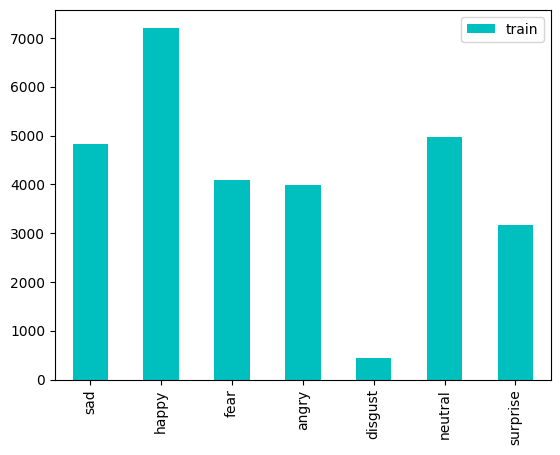

In [24]:
train_count.transpose().plot(kind='bar', color = 'c')

<Axes: >

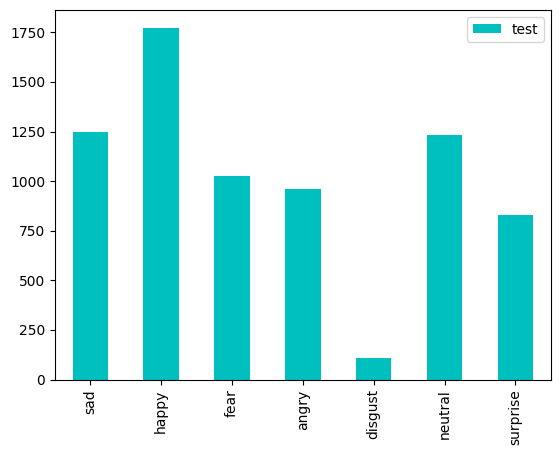

In [25]:
test_count.transpose().plot(kind='bar', color = 'c')

### Plotting one image from each emotion.

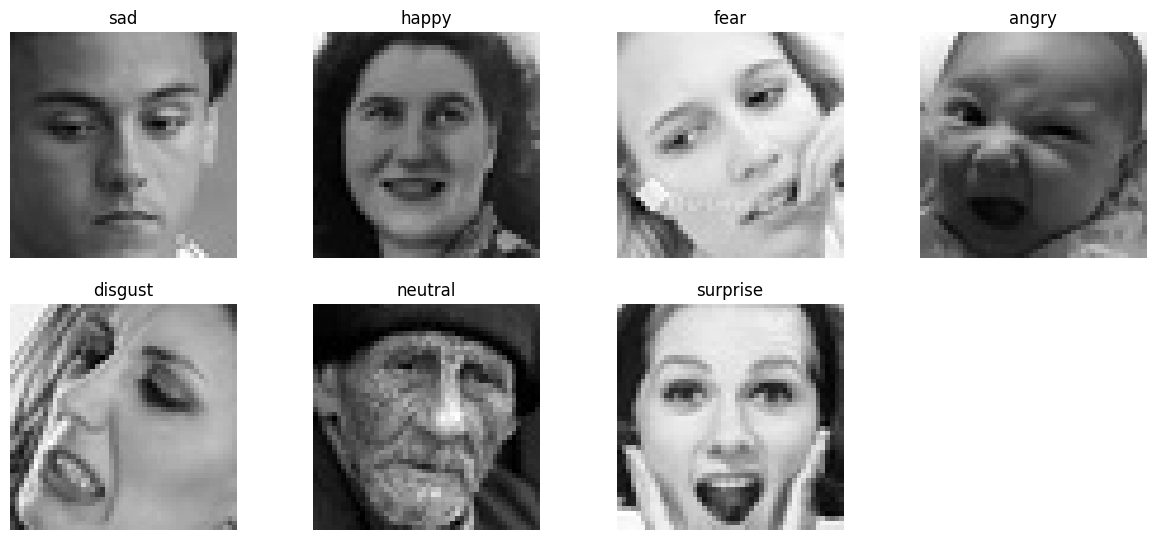

In [26]:
emotions = os.listdir(train_dir)
plt.figure(figsize=(15,10))

for i, emotion in enumerate(emotions, 1):
    folder = os.path.join(train_dir, emotion)
    img_path = os.path.join(folder, os.listdir(folder)[2])
    img = plt.imread(img_path)
    plt.subplot(3, 4, i)
    plt.imshow(img, cmap='gray')
    plt.title(emotion)
    plt.axis('off')

### Checking shapes and channels.

In [27]:
image = '/content/train/angry/Training_10118481.jpg'

import cv2

img = cv2.imread(image, cv2.IMREAD_GRAYSCALE) # Default load in color format.

# If the image is loaded successfully, print its pixel values
if img is not None:
    # print(img)
    print("Shape:", img.shape)
else:
    print("The image could not be loaded. Please check the path and file permissions.")

Shape: (48, 48)


### Model : Transfer Leanring - ResNet50

In [28]:
# Directory paths for training and testing data
train_dir = '/content/train'
test_dir = '/content/test'

# Batch size for data generators
batch_size = 64

# Data augmentation configuration for training data
train_datagen = ImageDataGenerator(
                                  rescale=1 / 255.,  # Rescale pixel values to [0,1]
                                  rotation_range=10,  # Random rotation within range [-10,10] degrees
                                  zoom_range=0.2,  # Random zoom between [0.8, 1.2]
                                  width_shift_range=0.1,  # Random horizontal shift within range [-0.1, 0.1]
                                  height_shift_range=0.1,  # Random vertical shift within range [-0.1, 0.1]
                                  horizontal_flip=True,  # Random horizontal flip
                                  fill_mode='nearest'  # Fill mode for handling newly created pixels
                                 )

# Configuration for testing data (only rescaling)
test_datagen = ImageDataGenerator(
                                  rescale=1 / 255.  # Rescale pixel values to [0,1]
                                 )

# Data generators for training and testing data
train_generator = train_datagen.flow_from_directory(
                                                    train_dir,  # Directory containing training data
                                                    class_mode="categorical",  # Classification mode for categorical labels
                                                    target_size=(224, 224),  # Resize input images to (224,224)
                                                    color_mode='rgb',  # Color mode for images (RGB)
                                                    shuffle=True,  # Shuffle training data
                                                    batch_size=batch_size,  # Batch size for training
                                                    subset='training'  # Subset of data (training)
                                                   )

test_generator = test_datagen.flow_from_directory(
                                                  test_dir,  # Directory containing testing data
                                                  class_mode="categorical",  # Classification mode for categorical labels
                                                  target_size=(224, 224),  # Resize input images to (224,224)
                                                  color_mode="rgb",  # Color mode for images (RGB)
                                                  shuffle=False,  # Do not shuffle testing data
                                                  batch_size=batch_size  # Batch size for testing
                                                 )


Found 28709 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.


### Introducing Class wieghts for imbalanced data

In [29]:
# Extract class labels for all instances in the training dataset
classes = np.array(train_generator.classes)

# Calculate class weights to handle imbalances in the training data
# 'balanced' mode automatically adjusts weights inversely proportional to class frequencies
class_weights = compute_class_weight(
    class_weight='balanced',  # Strategy to balance classes
    classes=np.unique(classes),  # Unique class labels
    y=classes  # Class labels for each instance in the training dataset
)

# Create a dictionary mapping class indices to their calculated weights
class_weights_dict = dict(enumerate(class_weights))

# Output the class weights dictionary
print("Class Weights Dictionary:", class_weights_dict)

Class Weights Dictionary: {0: 1.0266046844269623, 1: 9.406618610747051, 2: 1.0010460615781582, 3: 0.5684387684387684, 4: 0.8260394187886635, 5: 0.8491274770777877, 6: 1.293372978330405}


In [30]:
ResNet50V2 = tf.keras.applications.ResNet50V2(input_shape=(224, 224, 3),
                                               include_top= False,
                                               weights='imagenet'
                                               )

In [31]:
# Freezing all layers except last 50

ResNet50V2.trainable = True

for layer in ResNet50V2.layers[:-50]:
    layer.trainable = False

In [32]:
def Create_ResNet50V2_Model():

    model = Sequential([
                      ResNet50V2,
                      Dropout(0.25),
                      BatchNormalization(),
                      Flatten(),
                      Dense(64, activation='relu'),
                      BatchNormalization(),
                      Dropout(0.5),
                      Dense(7,activation='softmax') # for seven classes
                    ])
    return model

In [ ]:
# model = Create_ResNet50V2_Model()
# model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50v2 (Functional)     (None, 7, 7, 2048)        23564800  
                                                                 
 dropout (Dropout)           (None, 7, 7, 2048)        0         
                                                                 
 batch_normalization (Batch  (None, 7, 7, 2048)        8192      
 Normalization)                                                  
                                                                 
 flatten (Flatten)           (None, 100352)            0         
                                                                 
 dense (Dense)               (None, 64)                6422592   
                                                                 
 batch_normalization_1 (Bat  (None, 64)                256       
 chNormalization)                                       

In [33]:
# model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [34]:
# File path for the model checkpoint
cnn_path = '/content/FER_2013_Emotion_Detection/ResNet50_Transfer_Learning'
name = 'ResNet50_Transfer_Learning.keras'
chk_path = os.path.join(cnn_path, name)

# Callback to save the model checkpoint
checkpoint = ModelCheckpoint(filepath=chk_path,
                             save_best_only=True,
                             verbose=1,
                             mode='min',
                             monitor='val_loss')

# Callback for early stopping
earlystop = EarlyStopping(monitor = 'val_accuracy',
                          patience = 7,
                          restore_best_weights = True,
                          verbose=1)

# Callback to reduce learning rate
reduce_lr = ReduceLROnPlateau(monitor='val_loss',
                              factor=0.2,
                              patience=2,
#                             min_lr=0.00005,
                              verbose=1)

# Callback to log training data to a CSV file
csv_logger = CSVLogger(os.path.join(cnn_path,'training.log'))

# Aggregating all callbacks into a list
callbacks = [checkpoint, earlystop, csv_logger]

train_steps_per_epoch = train_generator.samples // train_generator.batch_size + 1
# validation_steps_epoch = validation_generator.samples // validation_generator.batch_size + 1
test_steps_epoch = test_generator.samples // test_generator.batch_size + 1

In [ ]:
# train_history = model.fit(
#                           train_generator,
#                           steps_per_epoch=train_steps_per_epoch,
#                           epochs=6,
#                           validation_data=test_generator,
#                           validation_steps=test_steps_epoch,
#                           class_weight=class_weights_dict,
#                           callbacks = callbacks
#                          )

In [ ]:

# model.save("Test_model.keras")

### Retraining


In [36]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import keras

# # Load the model
model = keras.models.load_model('/content/drive/MyDrive/ED_model_RT_19.keras')

In [35]:
# train_history = model.fit(
#                           train_generator,
#                           steps_per_epoch=train_steps_per_epoch,
#                           epochs=3, done earlier for 20 epoch
#                           validation_data=test_generator,
#                           validation_steps=test_steps_epoch,
#                           class_weight=class_weights_dict,
#                           callbacks = callbacks
#                          )

In [27]:
# model.save("ED_model_RT_19.keras")

In [28]:
# !cp /content/ED_model_RT_19.keras /content/drive/MyDrive/

In [37]:
test_loss, test_accu = model.evaluate(test_generator)
print(test_loss, test_accu)

113/113 [==============================] - 1391s 12s/step - loss: 0.9804 - accuracy: 0.6513
0.9804336428642273 0.6512956023216248


### Deployment


In [7]:
!pip3 install gradio

In [4]:
import numpy as np
from tensorflow.keras.preprocessing.image import img_to_array, load_img
import gradio as gr
import tensorflow as tf
import numpy as np
from PIL import Image
import cv2
from tensorflow.keras.preprocessing import image

In [5]:
emotion_labels = {'angry': 0, 'disgust': 1, 'fear': 2, 'happy': 3, 'neutral': 4, 'sad': 5, 'surprise': 6}
index_to_emotion = {v: k for k, v in emotion_labels.items()}
index_to_emotion

{0: 'angry',
 1: 'disgust',
 2: 'fear',
 3: 'happy',
 4: 'neutral',
 5: 'sad',
 6: 'surprise'}

In [14]:
def prepare_image(img_pil):
    """Preprocess the PIL image to fit your model's input requirements."""
    # Convert the PIL image to a numpy array with the target size
    img = img_pil.resize((224, 224))
    img_array = img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)  # Convert single image to a batch.
    img_array /= 255.0  # Rescale pixel values to [0,1], as done during training
    return img_array



# Define the Gradio interface
def predict_emotion(image):
    # Preprocess the image
    processed_image = prepare_image(image)
    # Make prediction using the model
    prediction = model.predict(processed_image)
    # Get the emotion label with the highest probability
    predicted_class = np.argmax(prediction, axis=1)
    predicted_emotion = index_to_emotion.get(predicted_class[0], "Unknown Emotion")
    return predicted_emotion

interface = gr.Interface(
    fn=predict_emotion,  # Your prediction function
    inputs=gr.Image(type="pil"),  # Input for uploading an image, directly compatible with PIL images
    outputs="text",  # Output as text displaying the predicted emotion
    title="Emotion Detection",
    description="Upload an image and see the predicted emotion."
)

# Launch the Gradio interface
interface.launch()


Setting queue=True in a Colab notebook requires sharing enabled. Setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
Running on public URL: https://2e8d7835eaff6218c4.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from Terminal to deploy to Spaces (https://huggingface.co/spaces)
